<a href="https://colab.research.google.com/github/KennethanCeyer/research/blob/master/DL/VAE/vanila_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q Pillow
!pip install -q image
!pip install -q torch torchvision

# Prepare dataset

In [2]:
!mkdir -p data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2020-11-25 17:24:17--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip.2’

celeba.zip.2        100%[===================>]   1.34G  95.0MB/s    in 14s     

2020-11-25 17:24:31 (95.5 MB/s) - ‘celeba.zip.2’ saved [1443490838/1443490838]



In [3]:
import os
import cv2
import zipfile
import itertools

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Subset

import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import PIL.Image as Image

In [4]:
def show(img, nrow=8, interpolation='bicubic'):
    img_grid = torchvision.utils.make_grid(img, nrow=nrow).numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(img_grid, (1, 2, 0)), interpolation=interpolation)
    plt.axis('off')
    plt.show()

In [5]:
with zipfile.ZipFile('celeba.zip', 'r') as zip_ref:
  zip_ref.extractall('data_faces/')

In [6]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)

print('=' * 43)
print('| {:20s} | Size: {:10,d} |'.format('Celeb A', len(img_list)))
print('=' * 43)

| Celeb A              | Size:    202,599 |


# Split the dataset to trains and test

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_size = 1024
latent_size = 128
data_size = 50000
crop_size = 128
img_size = 128
img_orig_width, img_orig_height = 218, 178
offset_height = (img_orig_width - crop_size) // 2
offset_width = (img_orig_height - crop_size) // 2
lr = 0.0001
epochs = 10
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['test'] = Subset(dataset, val_idx)
    return datasets

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(crop),
        transforms.ToPILImage(),
        transforms.Resize(size=img_size, interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
    ],
)

batch_size = 64
dataset = datasets.ImageFolder('./data_faces', transform=transform)
dataset = train_val_dataset(Subset(dataset, range(data_size)))
data_loader = {x: DataLoader(dataset[x], batch_size=batch_size, shuffle=True) for x in ['train','test']}
train_ds, test_ds = data_loader['train'], data_loader['test']

In [8]:
print('=' * 43)
print('| {:20s} | Size: {:10,d} |'.format('Train dataset', len(train_ds)))
print('| {:20s} | Size: {:10,d} |'.format('Test dataset', len(test_ds)))
print('=' * 43)

| Train dataset        | Size:        625 |
| Test dataset         | Size:        157 |


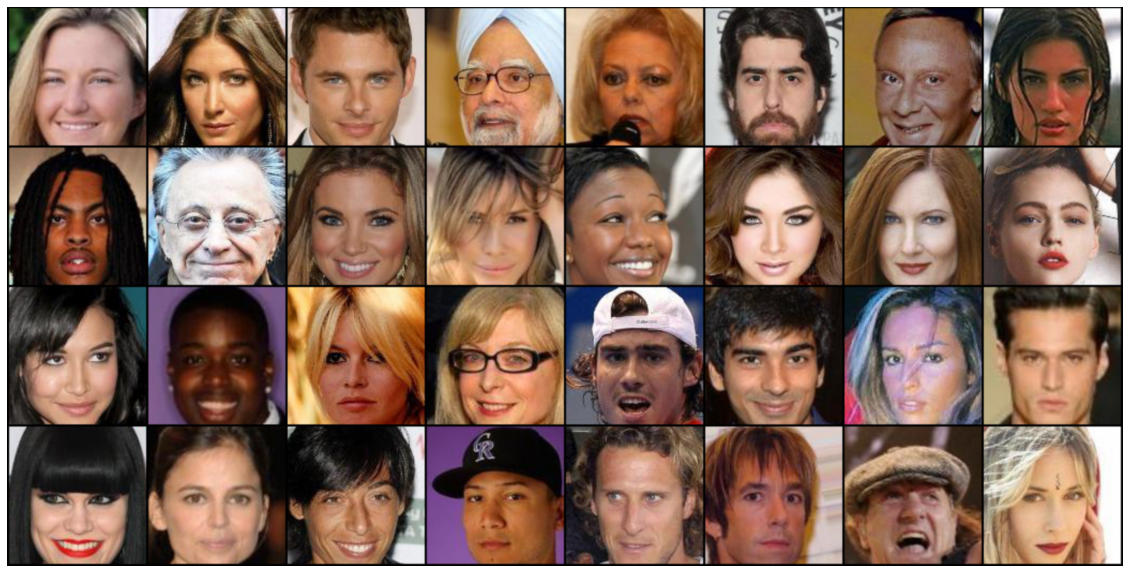

In [9]:
batch, _ = next(iter(train_ds))
show(batch[0:32], nrow=8)

# Utilities

In [10]:
def plot_loss(history):
    plot_train = np.array(history['train'])
    is_val = ('test' in history.keys())
    if is_val:
        plot_val = np.array(history['test'])

    n_epochs = len(plot_train)
    x = [i for i in range(1, n_epochs+1)]
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.xlabel('epoch')
    plt.plot(x, plot_train[:], label='train loss')
    if is_val:
        plt.plot(x, plot_val[:], label='test loss')

    plt.legend()
    plt.show()

In [11]:
def plot_gallery(images, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(5, 5))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        img = images[i]
        plt.imshow(img, interpolation='bicubic')
        plt.axis('off')
        if with_title:
            plt.title(titles[i])

# VAE Architecture

In [12]:
class VAE(nn.Module):
    def __init__(self, nc=3, ngf=128, ndf=128, latent_variable_size=1024):
        super(VAE, self).__init__()

        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        self.latent_variable_size = latent_variable_size

        # encoder
        self.e1 = nn.Conv2d(nc, ndf, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(ndf)

        self.e2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(ndf*2)

        self.e3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(ndf*4)

        self.e4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(ndf*8)

        self.e5 = nn.Conv2d(ndf*8, ndf*8, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(ndf*8)

        self.fc1 = nn.Linear(ndf*8*4*4, latent_variable_size)
        self.fc2 = nn.Linear(ndf*8*4*4, latent_variable_size)

        # decoder
        self.d1 = nn.Linear(latent_variable_size, ngf*8*2*4*4)

        self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd1 = nn.ReplicationPad2d(1)
        self.d2 = nn.Conv2d(ngf*8*2, ngf*8, 3, 1)
        self.bn6 = nn.BatchNorm2d(ngf*8, 1.e-3)

        self.up2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd2 = nn.ReplicationPad2d(1)
        self.d3 = nn.Conv2d(ngf*8, ngf*4, 3, 1)
        self.bn7 = nn.BatchNorm2d(ngf*4, 1.e-3)

        self.up3 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd3 = nn.ReplicationPad2d(1)
        self.d4 = nn.Conv2d(ngf*4, ngf*2, 3, 1)
        self.bn8 = nn.BatchNorm2d(ngf*2, 1.e-3)

        self.up4 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd4 = nn.ReplicationPad2d(1)
        self.d5 = nn.Conv2d(ngf*2, ngf, 3, 1)
        self.bn9 = nn.BatchNorm2d(ngf, 1.e-3)

        self.up5 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd5 = nn.ReplicationPad2d(1)
        self.d6 = nn.Conv2d(ngf, nc, 3, 1)

        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.leakyrelu(self.bn1(self.e1(x)))
        h2 = self.leakyrelu(self.bn2(self.e2(h1)))
        h3 = self.leakyrelu(self.bn3(self.e3(h2)))
        h4 = self.leakyrelu(self.bn4(self.e4(h3)))
        h5 = self.leakyrelu(self.bn5(self.e5(h4)))
        h5 = h5.view(-1, self.ndf*8*4*4)

        return self.fc1(h5), self.fc2(h5)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device)
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h1 = self.relu(self.d1(z))
        h1 = h1.view(-1, self.ngf*8*2, 4, 4)
        h2 = self.leakyrelu(self.bn6(self.d2(self.pd1(self.up1(h1)))))
        h3 = self.leakyrelu(self.bn7(self.d3(self.pd2(self.up2(h2)))))
        h4 = self.leakyrelu(self.bn8(self.d4(self.pd3(self.up3(h3)))))
        h5 = self.leakyrelu(self.bn9(self.d5(self.pd4(self.up4(h4)))))

        return self.sigmoid(self.d6(self.pd5(self.up5(h5))))

    def get_latent_var(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, mu, logvar

In [13]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [14]:
def loss_function(x, recon_x, mu, logvar):
    bce_loss = nn.BCELoss()
    BCE = bce_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Train

In [ ]:
history = {"train": [], "test": []}
for epoch in range(epochs):
    for phase in ["train", "test"]:
        if phase == "train":
            model.train(True)
            print(f"\n----- Epoch {epoch+1} -----")
        else: model.train(False)

        running_loss = 0.0
        data_num = 0

        for i, (x, _) in enumerate(data_loader[phase]):
            if phase == 'train':
                optimizer.zero_grad()
                x = x.to(device)
                recon_x, mean, logvar = model(x)
                loss = loss_function(x, recon_x, mean, logvar)
                model.zero_grad()
                loss.backward()
                optimizer.step()

                if i == 0:
                    x_sample = (x.clone().cpu().detach().numpy() * 255).astype(np.uint8)[0].transpose(1, 2, 0)
                    recon_x_sample = (recon_x.clone().cpu().detach().numpy() * 255).astype(np.uint8)[0].transpose(1, 2, 0)
                    plot_gallery([x_sample, recon_x_sample], 1, 2)
            elif phase == 'test':
                with torch.no_grad():
                    x = x.to(device)
                    recon_x, mean, logvar = model(x)
                    loss = loss_function(x, recon_x.to(device), mean, logvar)

                    # Visualize
                    if i == 0:
                        x_sample = (x.clone().cpu().detach().numpy() * 255).astype(np.uint8)[0].transpose(1, 2, 0)
                        output_sample = (recon_x.clone().cpu().detach().numpy() * 255).astype(np.uint8)[0].transpose(1, 2, 0)
                        plot_gallery([x_sample, output_sample], 1, 2)

            running_loss += loss
            data_num += x.size(0)

        epoch_loss = running_loss / data_num
        print("phase {:8s} Loss : {:.4f}".format(phase, epoch_loss))
        history[phase].append(epoch_loss)


----- Epoch 1 -----
phase train    Loss : 2.0081
phase test     Loss : 0.1440

----- Epoch 2 -----
phase train    Loss : 0.1422
phase test     Loss : 0.1805

----- Epoch 3 -----
phase train    Loss : 1.3309
phase test     Loss : 1.9205

----- Epoch 4 -----
phase train    Loss : 19.7250
phase test     Loss : 2.2209

----- Epoch 5 -----
phase train    Loss : 2.3838
phase test     Loss : 2.3185

----- Epoch 6 -----


In [ ]:
plot_loss(history)